# Detect Players in the Hull

In [59]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

from Plot import plot_cv, plot_img
from Cnn_Architecture import CourtDetection

In [60]:
model_path = "../Cnn_Architecture/court/keypoints_model.pth"
court_line = CourtDetection(model_path)

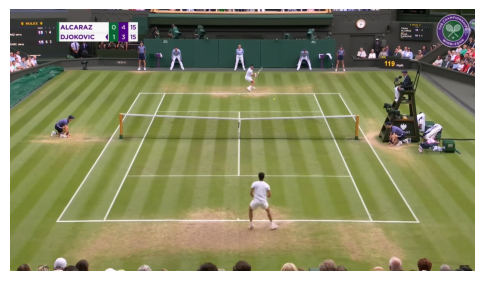

In [61]:
path = "../Data/tennis_game_3.png"
tennis = cv.imread(path, cv.IMREAD_COLOR_RGB)
plot_img(tennis)

In [62]:
pts = court_line.predict(tennis)
pts

array([     557.28,      328.61,      1350.5,      328.15,      232.95,      878.08,      1673.6,      874.24,      656.85,      328.51,      414.66,       877.5,      1251.4,      328.16,      1494.1,      874.58,      623.14,      406.99,        1285,      406.34,      502.64,      683.48,      1406.6,      681.73,
            953.97,      406.66,      955.04,      682.76], dtype=float32)

In [63]:
points = np.array(pts, dtype=np.float32).reshape(-1, 2)
Height, Width, channels = tennis.shape
black = np.zeros((Height, Width, channels), dtype=np.uint8)

In [64]:
for (x, y) in points:
    cv.circle(black, (int(x), int(y)), 8, (0, 255, 0), -1)
    cv.circle(tennis, (int(x), int(y)), 8, (0, 255, 0), -1)

In [65]:
hull = cv.convexHull(points)
hull_int = hull.astype(int)  
cv.polylines(black, [hull_int], isClosed=True, color=(0, 0, 255), thickness=2)
cv.polylines(tennis, [hull_int], isClosed=True, color=(0, 0, 255), thickness=2)

array([[[ 85,  88, 105],
        [ 85,  88, 105],
        [ 85,  88, 105],
        ...,
        [ 30,  37,  17],
        [ 31,  38,  18],
        [ 31,  38,  17]],

       [[ 85,  88, 105],
        [ 84,  88, 104],
        [ 85,  88, 105],
        ...,
        [ 31,  38,  19],
        [ 31,  38,  18],
        [ 32,  38,  19]],

       [[ 85,  88, 105],
        [ 85,  88, 105],
        [ 85,  88, 105],
        ...,
        [ 32,  39,  20],
        [ 33,  39,  21],
        [ 32,  38,  20]],

       ...,

       [[136, 147,  76],
        [136, 148,  76],
        [136, 147,  76],
        ...,
        [133, 134,  80],
        [133, 134,  80],
        [134, 135,  80]],

       [[138, 149,  78],
        [137, 148,  77],
        [137, 149,  78],
        ...,
        [135, 136,  83],
        [135, 136,  83],
        [134, 135,  82]],

       [[136, 147,  76],
        [136, 147,  76],
        [136, 147,  76],
        ...,
        [133, 134,  82],
        [133, 134,  81],
        [133, 134,  82]]

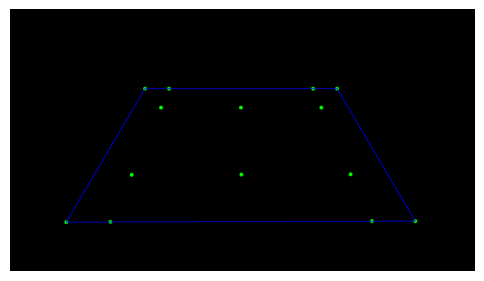

In [66]:
plot_img(black)

## Detect Players

In [67]:
model = YOLO("yolo11n.pt")
out = model.predict(tennis, conf = 0.45)


0: 384x640 8 persons, 104.1ms
Speed: 2.5ms preprocess, 104.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


## Bouding Box Distance using the Feet

In [68]:
feet_img = tennis.copy()
for result in out:
    boxes = result.boxes  

    for box in boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])  
        conf = box.conf[0]  
        cls = int(box.cls[0])  

        cv.rectangle(feet_img, (x1, y1), (x2, y2), (0, 255, 0), 2)  
        label = f"Class {cls}, Conf: {conf:.2f}"
        cv.putText(feet_img, label, (x1, y1 - 10), cv.FONT_HERSHEY_COMPLEX, 1, (255, 255, 255), 2)

        cx, cy = int((x1+x2) / 2), int(y2)
        player_point = (cx, cy)

        inside = cv.pointPolygonTest(hull, player_point, False)
        dist   = cv.pointPolygonTest(hull, player_point, True)

        if inside >= 0: #in the hall
            color = (0, 255, 0) 
            status = "inside"
        else: #out of the hall
            color = (0, 0, 0) 
            status = f"dist {dist:.1f}"

        cv.circle(feet_img, player_point, 6, color, -1)
        cv.putText(feet_img, status, (cx, cy + 20), cv.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
    

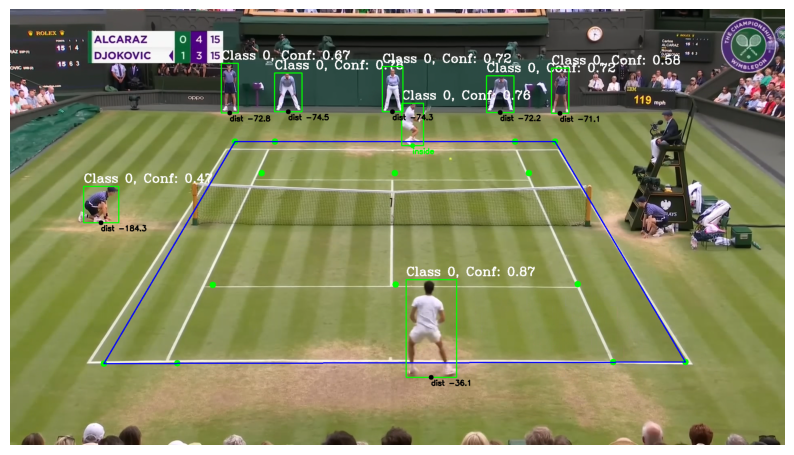

In [69]:
plot_img(feet_img, size=(10, 8))

## Bounding Box Using the Center

In [70]:
body_img = tennis.copy()
for result in out:
    boxes = result.boxes  

    for box in boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])  
        conf = box.conf[0]  
        cls = int(box.cls[0])  

        cv.rectangle(body_img, (x1, y1), (x2, y2), (0, 255, 0), 2)  
        label = f"Class {cls}, Conf: {conf:.2f}"
        cv.putText(body_img, label, (x1, y1 - 10), cv.FONT_HERSHEY_COMPLEX, 1, (255, 255, 255), 2)

        cx, cy = int((x1+x2) / 2), int((y1+y2) / 2)
        player_point = (cx, cy)

        inside = cv.pointPolygonTest(hull, player_point, False)
        dist   = cv.pointPolygonTest(hull, player_point, True)

        if inside >= 0: #in the hall
            color = (0, 255, 0) 
            status = "inside"
        else: #out of the hall
            color = (0, 0, 0) 
            status = f"dist {dist:.1f}"

        cv.circle(body_img, player_point, 6, color, -1)
        cv.putText(body_img, status, (cx, cy + 20), cv.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
    

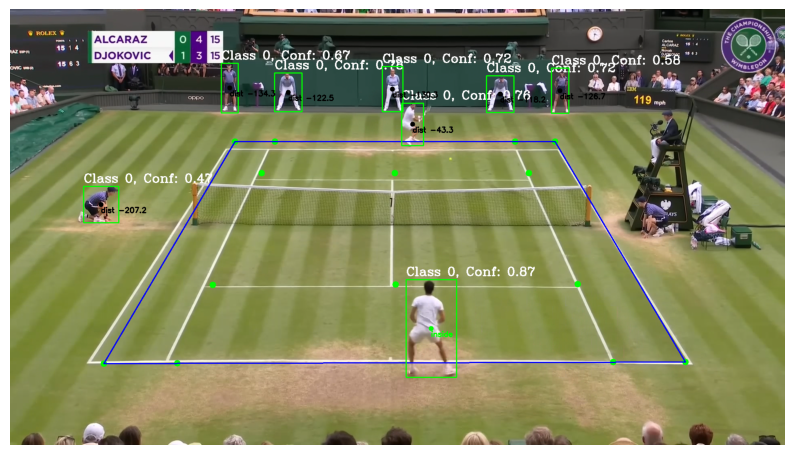

In [71]:
plot_img(body_img, size=(10, 8))

## Filter Using Both (Feet and Body) From the Hall

In this i only wanna show the bboxes that are close to a max distance

In [72]:
max_dist = 70
img__filter = tennis.copy()

for result in out:
    boxes = result.boxes  

    for box in boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])  
        conf = box.conf[0]  
        cls = int(box.cls[0])  

        feet_cx, feet_cy = int((x1 + x2) / 2), int(y2) #feet
        body_cx, body_cy = int((x1+x2) / 2), int((y1+y2) / 2) #center of body
        feet_point = (feet_cx, feet_cy)
        body_point = (body_cx, body_cy)

        #hull distance
        feet_inside = cv.pointPolygonTest(hull, feet_point, False)
        feet_dist   = cv.pointPolygonTest(hull, feet_point, True)

        body_inside = cv.pointPolygonTest(hull, body_point, False)
        body_dist   = cv.pointPolygonTest(hull, body_point, True)

        #if the player is inside or in a number max of pixels
        if feet_inside >= 0:
            ref_point = feet_point
            status = "inside"
            min_dist = 0
        elif body_inside >= 0:
            ref_point = body_point
            status = "inside"
            min_dist = 0
        else: #out of the hall
            if abs(feet_dist) <= abs(body_dist):
                ref_point = feet_point
                min_dist = abs(feet_dist)
            else:
                ref_point = body_point
                min_dist = abs(body_dist)
            if min_dist > max_dist:
                continue
            status = f"dist {min_dist:.1f}"

        cv.rectangle(img__filter, (x1, y1), (x2, y2), (0, 255, 0), 2)  
        label = f"Class {cls}, Conf: {conf:.2f}"
        cv.putText(img__filter, label, (x1, y1 - 10), cv.FONT_HERSHEY_COMPLEX, 1, (255, 255, 255), 2)

        cv.circle(img__filter, ref_point, 6, (0, 255, 0), -1)
        cv.putText(img__filter, status, (ref_point[0], ref_point[1] + 20),cv.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
            

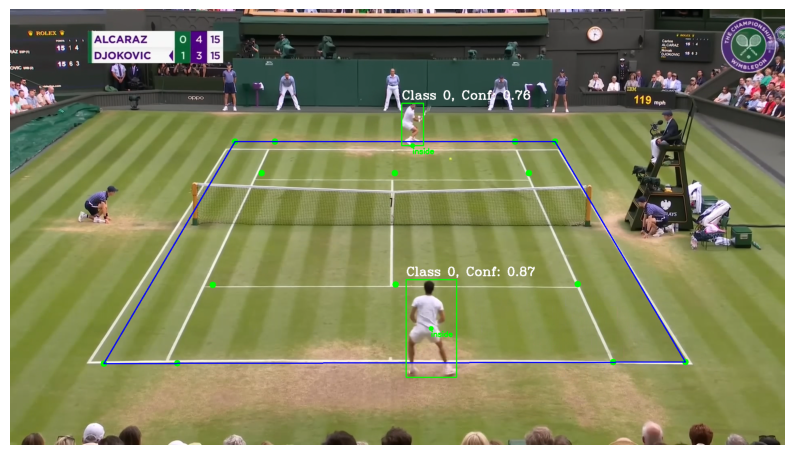

In [73]:
plot_img(img__filter, size=(10, 8))